# Import Packages / Libraries

In [145]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import os 
import glob
import random
import shutil
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import nasnet, resnet50, densenet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, fbeta_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

%matplotlib inline

# Import File for DataFrame

In [146]:
df = pd.read_csv('cicada.csv')

In [147]:
df.head(2)

,IMAGE_ID,STATUS
0,comphotos132842002medium.jpg,0
1,comphotos132843559medium.jpeg,0


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   IMAGE_ID  1143 non-null   object
 1   STATUS    1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [149]:
print(df['STATUS'])

0       0
1       0
2       0
3       0
4       0
       ..
1138    1
1139    1
1140    1
1141    1
1142    1
Name: STATUS, Length: 1143, dtype: int64


In [150]:
df['STATUS'] = df['STATUS'].astype(str)

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   IMAGE_ID  1143 non-null   object
 1   STATUS    1143 non-null   object
dtypes: object(2)
memory usage: 18.0+ KB


In [152]:
y = df['STATUS']
X = df

# Test Train Split

In [153]:
X_train_and_val , X_test, y_train_and_val, y_test = train_test_split(X, y,
                                            shuffle=True,
                                            test_size=0.2,
#                                            test_size=0.25,
                                            random_state = 201,
                                            stratify=y)

In [154]:
X_train , X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val,
                                            shuffle=True,
                                            test_size=0.16,
                                            random_state = 201,
                                            stratify=y_train_and_val)

In [155]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data and test data should not be augmented!

validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [156]:
X_train.head(2)

,IMAGE_ID,STATUS
854,comphotos135782857medium.jpg,1
195,comphotos133186810medium.jpg,0


# Create Generators from DataFrames for Train, Validation, and Test

In [157]:
train_generator = train_datagen.flow_from_dataframe(
    X_train,
    directory='data_images',
    x_col='IMAGE_ID',
    y_col='STATUS',
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=20,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
    #**kwargs
)

Found 767 validated image filenames belonging to 2 classes.


In [158]:
validation_generator = validation_datagen.flow_from_dataframe(
    X_val,
    directory='data_images',
    x_col='IMAGE_ID',
    y_col='STATUS',
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=20,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
    #**kwargs
)

Found 147 validated image filenames belonging to 2 classes.


In [159]:
test_generator = test_datagen.flow_from_dataframe(
    X_test,
    directory='data_images',
    x_col='IMAGE_ID',
    y_col='STATUS',
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=20,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
    #**kwargs
)

Found 229 validated image filenames belonging to 2 classes.


# VGG16 Model

In [160]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (256, 256, 3), 

include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [161]:
for layer in base_model.layers:
    layer.trainable = False

In [162]:
#freeze / unfreeze then model.fit


# Flatten the output layer to 1 dimension
X = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
X = layers.Dense(512, activation='relu')(X)

# Add a dropout rate of 0.5
X = layers.Dropout(0.5)(X)

# Add a final sigmoid layer with 1 node for classification output
X = layers.Dense(1, activation='sigmoid')(X)

model = tf.keras.models.Model(base_model.input, X)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [163]:
# ORIGINAL vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)
vgghist16 = model.fit(train_generator, 
                    validation_data = validation_generator,
                    verbose=1, epochs=4)

Epoch 1/4


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 331s 8s/step - acc: 0.5450 - loss: 1.1596 - val_acc: 0.6599 - val_loss: 0.6531
Epoch 2/4
39/39 ━━━━━━━━━━━━━━━━━━━━ 313s 8s/step - acc: 0.6291 - loss: 0.6794 - val_acc: 0.6531 - val_loss: 0.6405
Epoch 3/4
39/39 ━━━━━━━━━━━━━━━━━━━━ 310s 8s/step - acc: 0.6262 - loss: 0.6776 - val_acc: 0.6599 - val_loss: 0.6286
Epoch 4/4
39/39 ━━━━━━━━━━━━━━━━━━━━ 339s 9s/step - acc: 0.6835 - loss: 0.6419 - val_acc: 0.6463 - val_loss: 0.7150


In [164]:
X_train['IMAGE_ID'][0]

'comphotos132842002medium.jpg'

In [165]:
labels = {}
labels[0] = 'Healthy'
labels[1] = 'Infected'
labels

{0: 'Healthy', 1: 'Infected'}

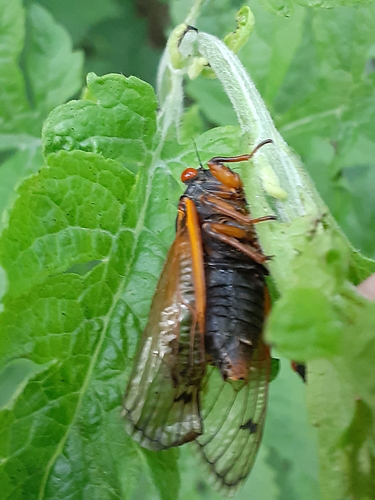

In [190]:
from PIL import Image
#title_obj = plt.title(labels)
img_ID = df.IMAGE_ID[2]
img = Image.open('data_images/'+img_ID)
display(img)

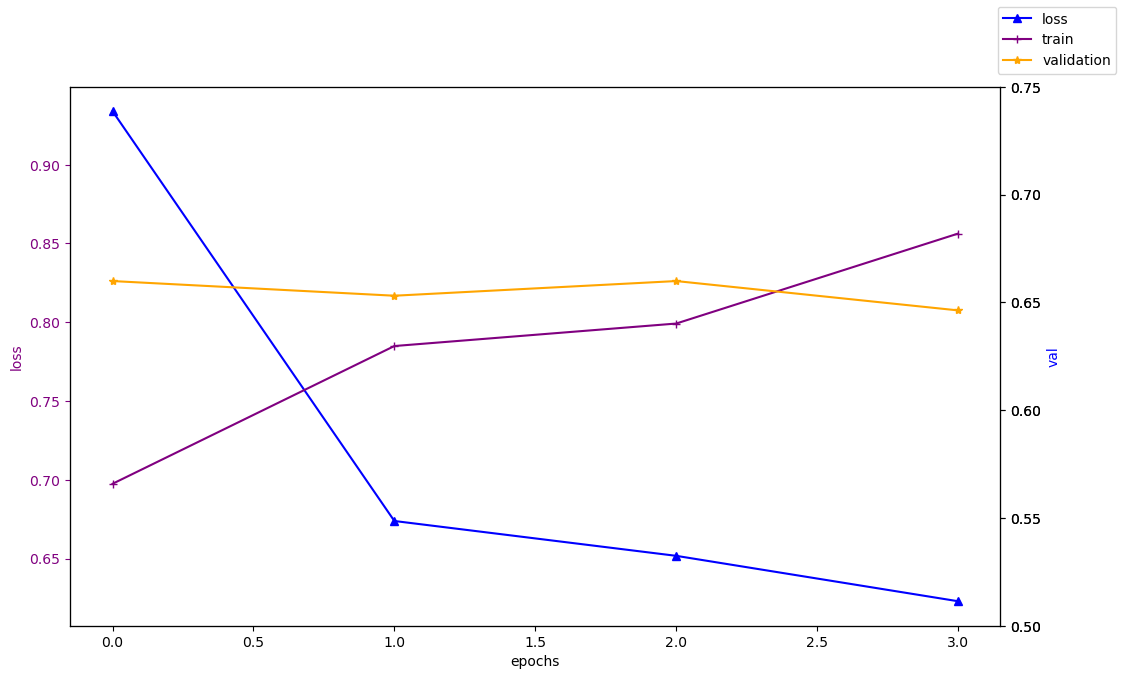

In [166]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(vgghist16.epoch, vgghist16.history['loss'], marker='^', color='blue', label='loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')
#ax1.set_ylim(0.5,1)

ax2 = ax1.twinx()
plt.plot(vgghist16.epoch, vgghist16.history['acc'], marker='+', color='purple', label='train')
ax2.set_ylabel('val', color='blue')
ax2.set_ylim((0.5,0.75))

ax3 = ax1.twinx()
plt.plot(vgghist16.epoch, vgghist16.history['val_acc'], marker='*', color='orange', label='validation')
ax3.set_ylim((0.5,0.75))

#ax4 = ax1.twinx()
#ax4.plot(vgghist16.epoch, vgghist16.history['val_loss'], marker='^', color='pink',label='val loss')
#ax4.set_xlabel('epochs')
#ax4.tick_params('y', colors='blue')
#ax4.set_ylim(0,1.2)


fig.legend();

In [167]:
#1.Predict classes
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = vgghist16.model.predict(test_generator)

# Get most likely class
predicted_classes = [1 * (x[0]>=0.5) for x in predictions]

# 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

# 3. Use scikit-learn to get statistics
from sklearn.metrics import confusion_matrix,classification_report,f1_score

print(class_labels)

print(confusion_matrix(test_generator.classes, predicted_classes))
print(fbeta_score)
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

12/12 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step
['0', '1']
[[ 13  94]
 [ 20 102]]
<function fbeta_score at 0x14cd3dee0>
              precision    recall  f1-score   support

           0       0.39      0.12      0.19       107
           1       0.52      0.84      0.64       122

    accuracy                           0.50       229
   macro avg       0.46      0.48      0.41       229
weighted avg       0.46      0.50      0.43       229



# VGG19 Model

# Import File for DataFrame

In [79]:
df = pd.read_csv('cicada.csv')

In [80]:
df.head(2)

,IMAGE_ID,STATUS
0,comphotos132842002medium.jpg,0
1,comphotos132843559medium.jpeg,0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   IMAGE_ID  1143 non-null   object
 1   STATUS    1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [82]:
print(df['STATUS'])

0       0
1       0
2       0
3       0
4       0
       ..
1138    1
1139    1
1140    1
1141    1
1142    1
Name: STATUS, Length: 1143, dtype: int64


In [83]:
df['STATUS'] = df['STATUS'].astype(str)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   IMAGE_ID  1143 non-null   object
 1   STATUS    1143 non-null   object
dtypes: object(2)
memory usage: 18.0+ KB


In [85]:
y = df['STATUS']
X = df

# Test Train Split

In [86]:
X_train_and_val , X_test, y_train_and_val, y_test = train_test_split(X, y,
                                            shuffle=True,
                                            test_size=0.2,
                                            random_state = 201,
                                            stratify=y)

In [87]:
X_train , X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val,
                                            shuffle=True,
                                            test_size=0.15,
                                            random_state = 201,
                                            stratify=y_train_and_val)

In [88]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data and test data should not be augmented!

validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [89]:
X_train.head(2)

,IMAGE_ID,STATUS
945,comphotos167025376medium.jpeg,1
291,comphotos133340076medium.jpg,0


# Create Generators from DataFrames for Train, Validation, and Test

In [90]:
train_generator = train_datagen.flow_from_dataframe(
    X_train,
    directory='data_images',
    x_col='IMAGE_ID',
    y_col='STATUS',
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=20,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
    #**kwargs
)

Found 776 validated image filenames belonging to 2 classes.


In [91]:
validation_generator = validation_datagen.flow_from_dataframe(
    X_val,
    directory='data_images',
    x_col='IMAGE_ID',
    y_col='STATUS',
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=20,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
    #**kwargs
)

Found 138 validated image filenames belonging to 2 classes.


In [92]:
test_generator = test_datagen.flow_from_dataframe(
    X_test,
    directory='data_images',
    x_col='IMAGE_ID',
    y_col='STATUS',
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=20,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
    #**kwargs
)

Found 229 validated image filenames belonging to 2 classes.


In [97]:
from tensorflow.keras.applications.vgg19 import VGG19

base_model = VGG19(input_shape = (256, 256, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [98]:
for layer in base_model.layers:
    layer.trainable = False

In [99]:
# Flatten the output layer to 1 dimension
X = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
X = layers.Dense(512, activation='relu')(X)

# Add a dropout rate of 0.5
X = layers.Dropout(0.5)(X)

# Add a final sigmoid layer with 1 node for classification output
X = layers.Dense(1, activation='sigmoid')(X)

model = tf.keras.models.Model(base_model.input, X)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [100]:
vgghist19 = model.fit(train_generator, validation_data = validation_generator,verbose=1, epochs=7)

Epoch 1/7


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 378s 10s/step - acc: 0.5558 - loss: 1.4323 - val_acc: 0.6014 - val_loss: 0.6980
Epoch 2/7
39/39 ━━━━━━━━━━━━━━━━━━━━ 364s 9s/step - acc: 0.5735 - loss: 0.7452 - val_acc: 0.7101 - val_loss: 0.6102
Epoch 3/7
39/39 ━━━━━━━━━━━━━━━━━━━━ 365s 9s/step - acc: 0.6451 - loss: 0.6416 - val_acc: 0.6232 - val_loss: 0.6301
Epoch 4/7
39/39 ━━━━━━━━━━━━━━━━━━━━ 354s 9s/step - acc: 0.6789 - loss: 0.6319 - val_acc: 0.6087 - val_loss: 0.6462
Epoch 5/7
39/39 ━━━━━━━━━━━━━━━━━━━━ 388s 10s/step - acc: 0.6857 - loss: 0.5966 - val_acc: 0.6957 - val_loss: 0.6045
Epoch 6/7
39/39 ━━━━━━━━━━━━━━━━━━━━ 403s 10s/step - acc: 0.6895 - loss: 0.5660 - val_acc: 0.6377 - val_loss: 0.6857
Epoch 7/7
39/39 ━━━━━━━━━━━━━━━━━━━━ 435s 11s/step - acc: 0.7183 - loss: 0.5670 - val_acc: 0.6884 - val_loss: 0.5866


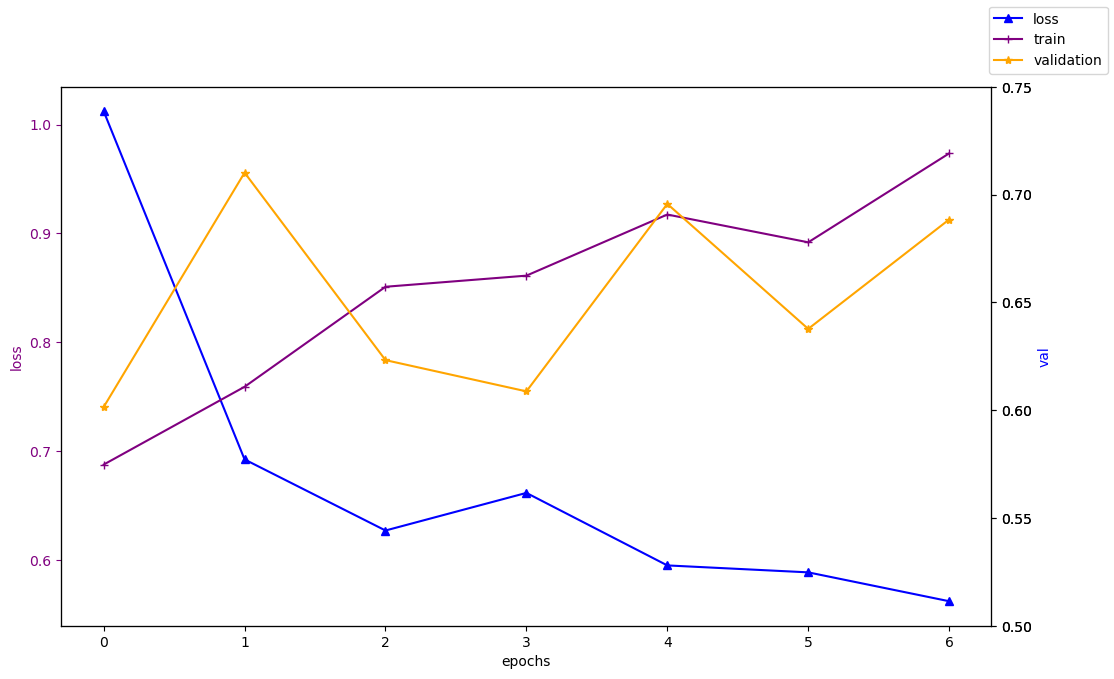

In [101]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(vgghist19.epoch, vgghist19.history['loss'], marker='^', color='blue', label='loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')
#ax1.set_ylim(0.5,1)

ax2 = ax1.twinx()
plt.plot(vgghist19.epoch, vgghist19.history['acc'], marker='+', color='purple', label='train')
ax2.set_ylabel('val', color='blue')
ax2.set_ylim((0.5,0.75))

ax3 = ax1.twinx()
plt.plot(vgghist19.epoch, vgghist19.history['val_acc'], marker='*', color='orange', label='validation')
ax3.set_ylim((0.5,0.75))

#ax4 = ax1.twinx()
#ax4.plot(vgghist16.epoch, vgghist16.history['val_loss'], marker='^', color='pink',label='val loss')
#ax4.set_xlabel('epochs')
#ax4.tick_params('y', colors='blue')
#ax4.set_ylim(0,1.2)


fig.legend();

In [102]:
#1.Predict classes
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = vgghist19.model.predict(test_generator)

# Get most likely class
predicted_classes = [1 * (x[0]>=0.5) for x in predictions]

# 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

# 3. Use scikit-learn to get statistics
from sklearn.metrics import confusion_matrix,classification_report,f1_score

print(class_labels)

print(confusion_matrix(test_generator.classes, predicted_classes))
print(fbeta_score)
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

12/12 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step
['0', '1']
[[52 55]
 [68 54]]
<function fbeta_score at 0x14cd3dee0>
              precision    recall  f1-score   support

           0       0.43      0.49      0.46       107
           1       0.50      0.44      0.47       122

    accuracy                           0.46       229
   macro avg       0.46      0.46      0.46       229
weighted avg       0.47      0.46      0.46       229



# Inceptionv2 model

# Import File for DataFrame

In [168]:
df = pd.read_csv('cicada.csv')

In [169]:
df.head(2)

,IMAGE_ID,STATUS
0,comphotos132842002medium.jpg,0
1,comphotos132843559medium.jpeg,0


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   IMAGE_ID  1143 non-null   object
 1   STATUS    1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [171]:
print(df['STATUS'])

0       0
1       0
2       0
3       0
4       0
       ..
1138    1
1139    1
1140    1
1141    1
1142    1
Name: STATUS, Length: 1143, dtype: int64


In [172]:
df['STATUS'] = df['STATUS'].astype(str)

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   IMAGE_ID  1143 non-null   object
 1   STATUS    1143 non-null   object
dtypes: object(2)
memory usage: 18.0+ KB


In [174]:
y = df['STATUS']
X = df

# Test Train Split

In [175]:
X_train_and_val , X_test, y_train_and_val, y_test = train_test_split(X, y,
                                            shuffle=True,
                                            test_size=0.2,
#                                            test_size=0.25,
                                            random_state = 201,
                                            stratify=y)

In [176]:
X_train , X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val,
                                            shuffle=True,
                                            test_size=0.16,
                                            random_state = 201,
                                            stratify=y_train_and_val)

In [177]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data and test data should not be augmented!

validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [178]:
X_train.head(2)

,IMAGE_ID,STATUS
854,comphotos135782857medium.jpg,1
195,comphotos133186810medium.jpg,0


# Create Generators from DataFrames for Train, Validation, and Test

In [179]:
train_generator = train_datagen.flow_from_dataframe(
    X_train,
    directory='data_images',
    x_col='IMAGE_ID',
    y_col='STATUS',
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=20,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
    #**kwargs
)

Found 767 validated image filenames belonging to 2 classes.


In [180]:
validation_generator = validation_datagen.flow_from_dataframe(
    X_val,
    directory='data_images',
    x_col='IMAGE_ID',
    y_col='STATUS',
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=20,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
    #**kwargs
)

Found 147 validated image filenames belonging to 2 classes.


In [181]:
test_generator = test_datagen.flow_from_dataframe(
    X_test,
    directory='data_images',
    x_col='IMAGE_ID',
    y_col='STATUS',
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=20,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
    #**kwargs
)

Found 229 validated image filenames belonging to 2 classes.


In [186]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

In [187]:
for layer in base_model.layers:
    layer.trainable = False

In [188]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [189]:
inchist = model.fit(train_generator, validation_data = validation_generator,verbose=1, epochs=5)

Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - acc: 0.5388 - loss: 8.4262 - val_acc: 0.6939 - val_loss: 0.7468
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - acc: 0.6952 - loss: 0.7395 - val_acc: 0.7007 - val_loss: 0.5193
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - acc: 0.6883 - loss: 0.7040 - val_acc: 0.7687 - val_loss: 0.4848
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - acc: 0.7424 - loss: 0.5498 - val_acc: 0.7007 - val_loss: 0.6267
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - acc: 0.7364 - loss: 0.5701 - val_acc: 0.7619 - val_loss: 0.5170


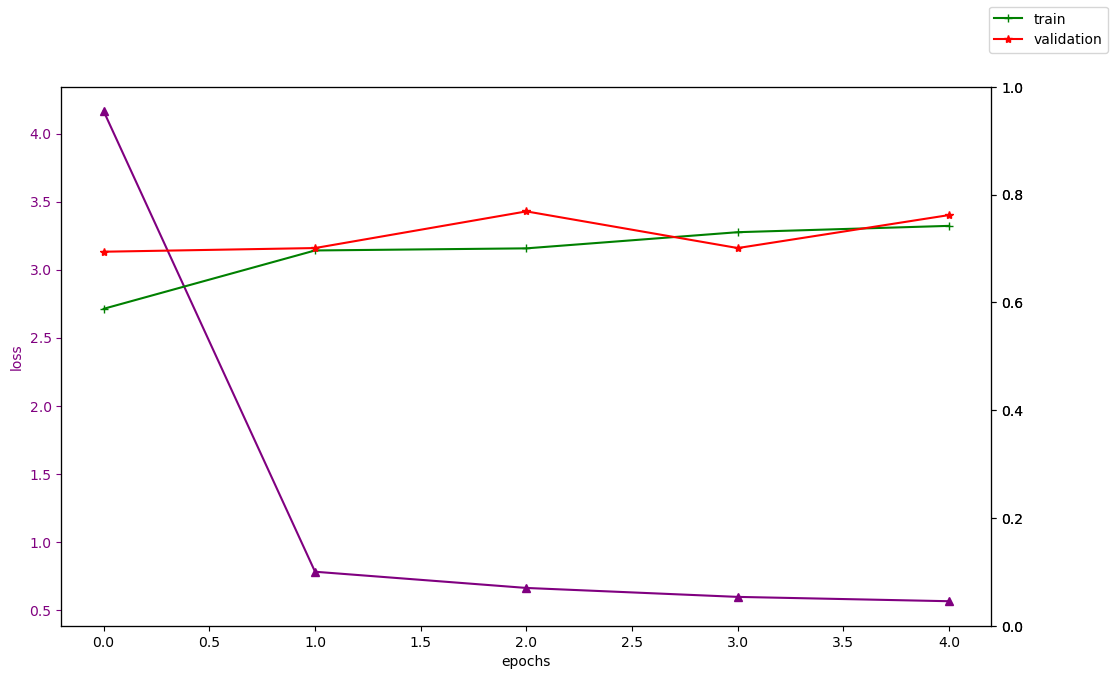

In [192]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(inchist.epoch, inchist.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(inchist.epoch, inchist.history['acc'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(inchist.epoch, inchist.history['val_acc'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)


fig.legend();

In [193]:
inchist = model.fit(test_generator,verbose=1, epochs=4)

Epoch 1/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - acc: 0.6990 - loss: 0.6841
Epoch 2/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - acc: 0.8478 - loss: 0.3264
Epoch 3/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - acc: 0.8685 - loss: 0.2637
Epoch 4/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - acc: 0.9470 - loss: 0.1491


In [195]:
#1.Predict classes
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = inchist.model.predict(test_generator)

# Get most likely class
predicted_classes = [1 * (x[0]>=0.5) for x in predictions]

# 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

# 3. Use scikit-learn to get statistics
from sklearn.metrics import confusion_matrix,classification_report

print(class_labels)

print(confusion_matrix(test_generator.classes, predicted_classes))

report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step
['0', '1']
[[52 55]
 [63 59]]
              precision    recall  f1-score   support

           0       0.45      0.49      0.47       107
           1       0.52      0.48      0.50       122

    accuracy                           0.48       229
   macro avg       0.48      0.48      0.48       229
weighted avg       0.49      0.48      0.49       229

